# Visualizing ML Decision Boundaries

## Navigation

1. [Auxiliary Functions](#Auxiliary-Functions)
1. [Data](#Data)
1. [Boundaries](#Boundaries)

In [505]:
import pandas as pd
import numpy as np
from itertools import product
# vis
from plotnine import *

import warnings
warnings.filterwarnings("ignore")

In [472]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## Auxiliary Functions

[Top](#Navigation)

In [548]:
def gen_data(ns = [100, 100, 100],
             means = [(0,0), (.5,1), (1, .5)],
             covs = [[[.1, .05], [.05, .1]],
                     [[.1, .05], [.05, .1]],
                     [[.1, .05], [.05, .1]]],
             clusters = None):
    """
    Generates data from 2-D multivariate normal distribution.
    
    Parameters
    ----------
    ns: number of samples for each cluster
    means: list of cluster centroids
    covs: list of covariance matrices.
    clusters: optional. list with cluster names.
    """
    assert (len(ns) == len(means) == len(covs)), "Length of all arrays must be equal."
    
    cluster_name = range(len(ns))
    if clusters is not None:
        assert(len(ns) == len(clusters))
        cluster_name = clusters
    data = pd.DataFrame()
    for indx, n in enumerate(ns):
        mean = means[indx]
        cov = covs[indx]
        curr_sample = np.random.multivariate_normal(mean, cov, n)
        curr_df = pd.DataFrame(curr_sample, 
                               columns=['x_{}'.format(i) for i in range(len(mean))])
        curr_df['cluster'] = cluster_name[indx]
        data = data.append(curr_df, ignore_index = True)
    data.cluster = data.cluster.astype('category')
    return data

In [549]:
# custom theme and colors
my_theme = (theme_void() +
                theme(
                axis_line=element_line(size=.75),
                axis_ticks=element_line(size=.75),
                axis_title=element_text(),
                )
           )
viridis = ["#440154ff", "#23988aff", "#fde725ff"]

def plot_data(data, 
              xname = "x_0", 
              yname = "x_1", 
              title = "", 
              xlab = "", 
              ylab = "", 
              color_var = "cluster",
              shape_var = "cluster",
              color = viridis, 
              shapes = ['o', '^', 's'],
              figure_size = (8, 6)):
    """
    Plot 2-D (labeled) data.
    Note: If you use more than 3 clusters, please supply colors and shapes.
    
    Parameters
    ----------
    ...
    """
    p = (ggplot(data, aes(xname, yname, color = color_var, shape = shape_var))
            + geom_point()
            + scale_color_manual(values = viridis, name = "Cluster")
            + scale_shape_manual(values = shapes, name = "Cluster")
            + labs(x = xlab, y = ylab, 
                   title = title)
            + my_theme
            + theme(figure_size = figure_size)
        )
    return p

In [550]:
def get_grid(data, N, xname = 'x_0', yname = 'x_1'):
    features = [xname, yname]
    x0_range, x1_range = data[features].apply(lambda x : (x.min(), x.max()))
    grid = product(np.linspace(x0_range[0], x0_range[1], num=N),
                   np.linspace(x1_range[0], x1_range[1], num=N))
    data_grid = pd.DataFrame([row for row in grid], columns=features)
    return data_grid

In [551]:
def get_decisions(clf, data_grid, model_name):
    data_grid['pred'] = pd.Series(clf.predict(data_grid)).astype('category')
    data_grid['method'] = model_name
    return data_grid

In [552]:
def plot_boundries(clfs, data, N, 
                   model_name = None,
                   xname = "x_0", 
                   yname = "x_1", 
                   title = "", 
                   xlab = "", 
                   ylab = "",
                   color_var = "cluster",
                   shape_var = "cluster", 
                   colors = viridis, 
                   shapes = ['o', '^', 's'],
                   figure_size = (8, 6)):
    """
    """
    data_grid = get_grid(data, N, xname, yname)
    
    if isinstance(clfs, dict):
        to_plot = pd.concat((get_decisions(model, data_grid.copy(), model_name) \
                                       for model_name, model in clfs.items()))
    else:
        to_plot = get_decisions(clfs, data_grid, model_name)
    # plot
    p = (ggplot(to_plot, aes(xname, yname, color = 'pred'))
        + geom_point(size = .001)
        + scale_color_manual(values = colors, name = shape_var) #  guide=False,
        + labs(x = xlab, y = ylab, 
               title = title)
        + my_theme
        + facet_wrap('method', nrow = 3)
        + theme(figure_size = figure_size)
        )
    p += (geom_point(data = data, mapping = aes(xname, yname, 
                                                color = color_var, 
                                                shape = shape_var),
                    fill="black", size = 2)
         )
    return p

## Data

[Top](#Navigation)

Sample mixed Gaussian data.

In [582]:
n = 200
n_clusters = 3
linear_data = gen_data(ns = [n] * n_clusters)
non_linear_data = gen_data(ns = [n] * n_clusters, clusters=[0, 1, 1])

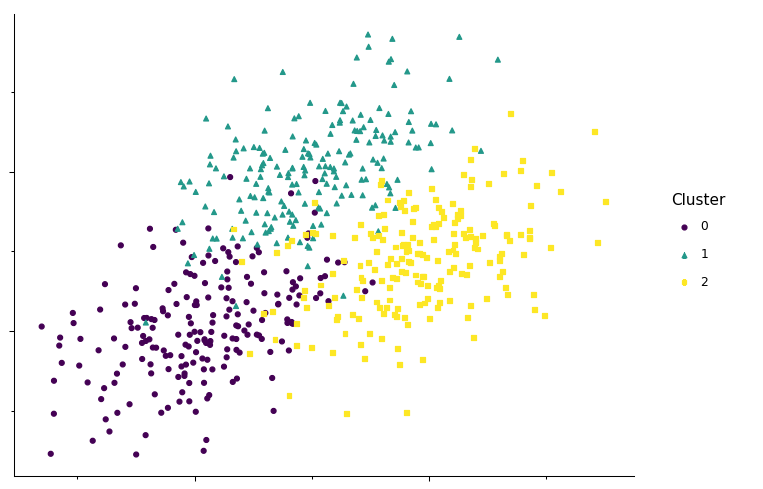

<ggplot: (-9223372029293382456)>

In [583]:
plot_data(linear_data)

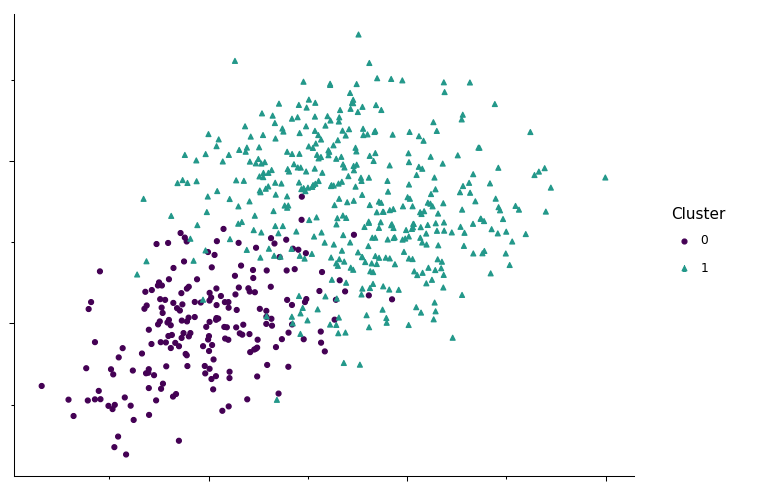

<ggplot: (7561318534)>

In [584]:
plot_data(non_linear_data)

## Boundaries

[Top](#Navigation)

### Classifiers

In [585]:
features = ['x_0', 'x_1']

In [586]:
X, y = linear_data[features], linear_data.cluster
non_lin_X, non_lin_y = non_linear_data[features], non_linear_data.cluster

In [587]:
lin_clfs = {'LR':LogisticRegression().fit(X, y), 
            'RF':RandomForestClassifier(n_estimators=100, 
                                        max_depth=4).fit(X, y),
            '5NN':KNeighborsClassifier().fit(X, y),
            'SVC':SVC().fit(X, y),
            'SVC-Poly':SVC(kernel='poly').fit(X, y),
            'NB':GaussianNB().fit(X, y)}

non_lin_clfs = {'LR':LogisticRegression().fit(non_lin_X, non_lin_y), 
                'RF':RandomForestClassifier(n_estimators=100, 
                                            max_depth=4).fit(non_lin_X, non_lin_y),
                '5NN':KNeighborsClassifier().fit(non_lin_X, non_lin_y),
                'SVC':SVC().fit(non_lin_X, non_lin_y),
                'SVC-Poly':SVC(kernel='poly').fit(non_lin_X, non_lin_y),
                'NB':GaussianNB().fit(non_lin_X, non_lin_y)}

### Single Classifier

##### Linear Boundaries

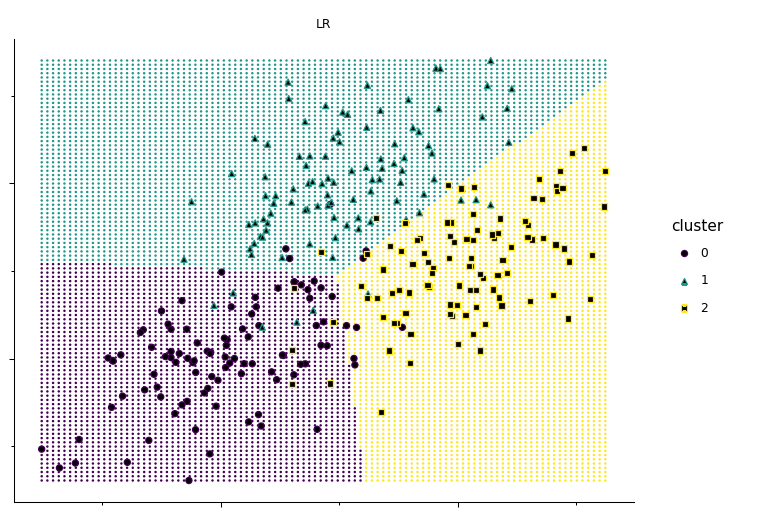

<ggplot: (-9223372029277994503)>

In [578]:
plot_boundries(lin_clfs['LR'], linear_data, 100, model_name = 'LR')

##### Non- Linear Boundaries

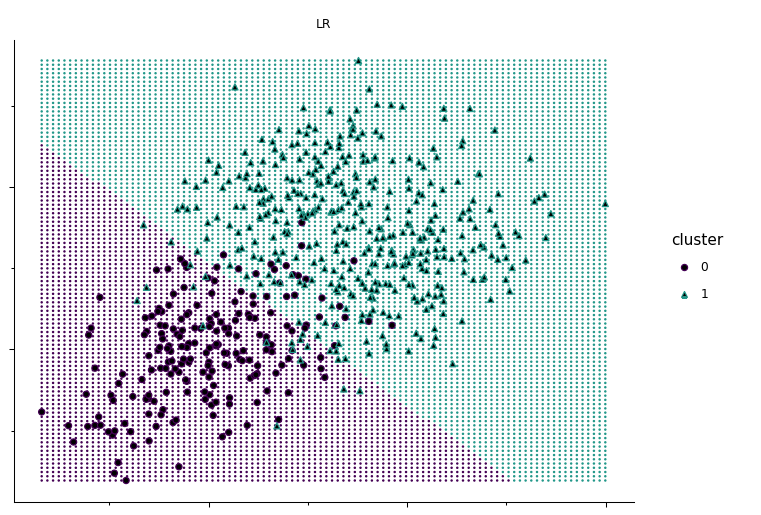

<ggplot: (-9223372029301139901)>

In [588]:
plot_boundries(non_lin_clfs['LR'], non_linear_data, 100, model_name = 'LR')

### Multiple Classifiers

##### Linear Boundaries

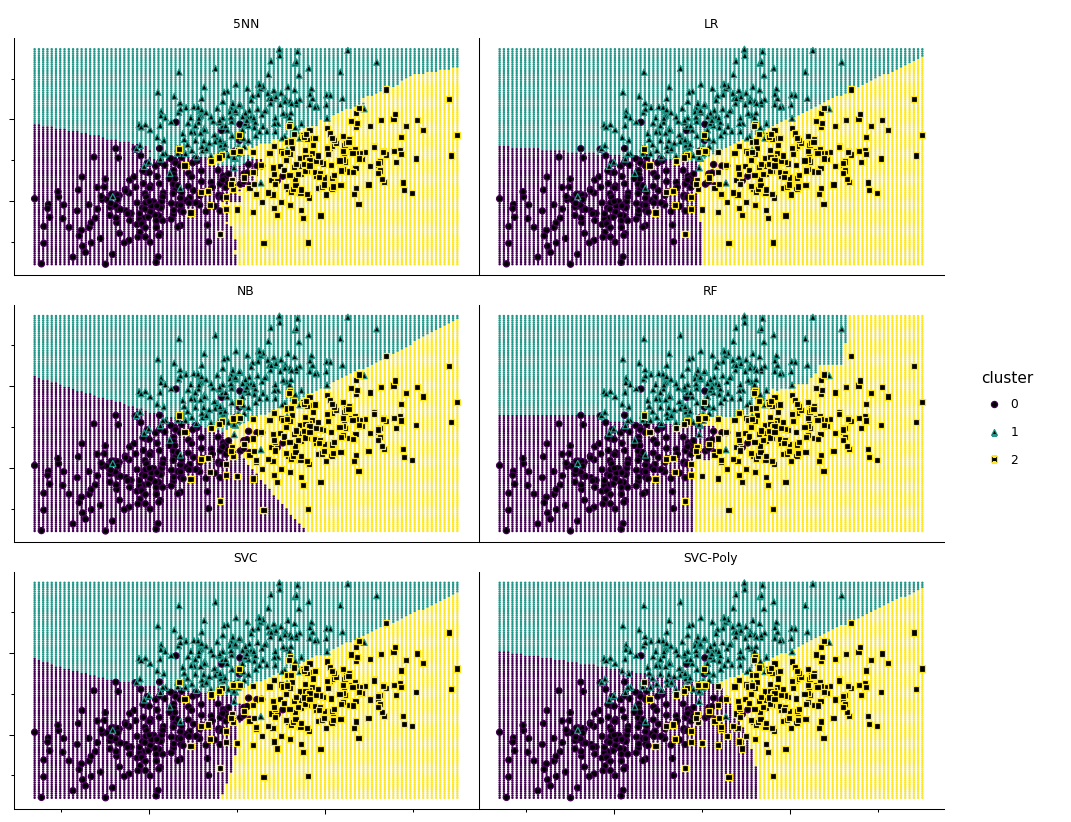

<ggplot: (-9223372029295711046)>

In [589]:
plot_boundries(lin_clfs, linear_data, 100, figure_size = (12, 10))

##### Non-Linear Boundaries

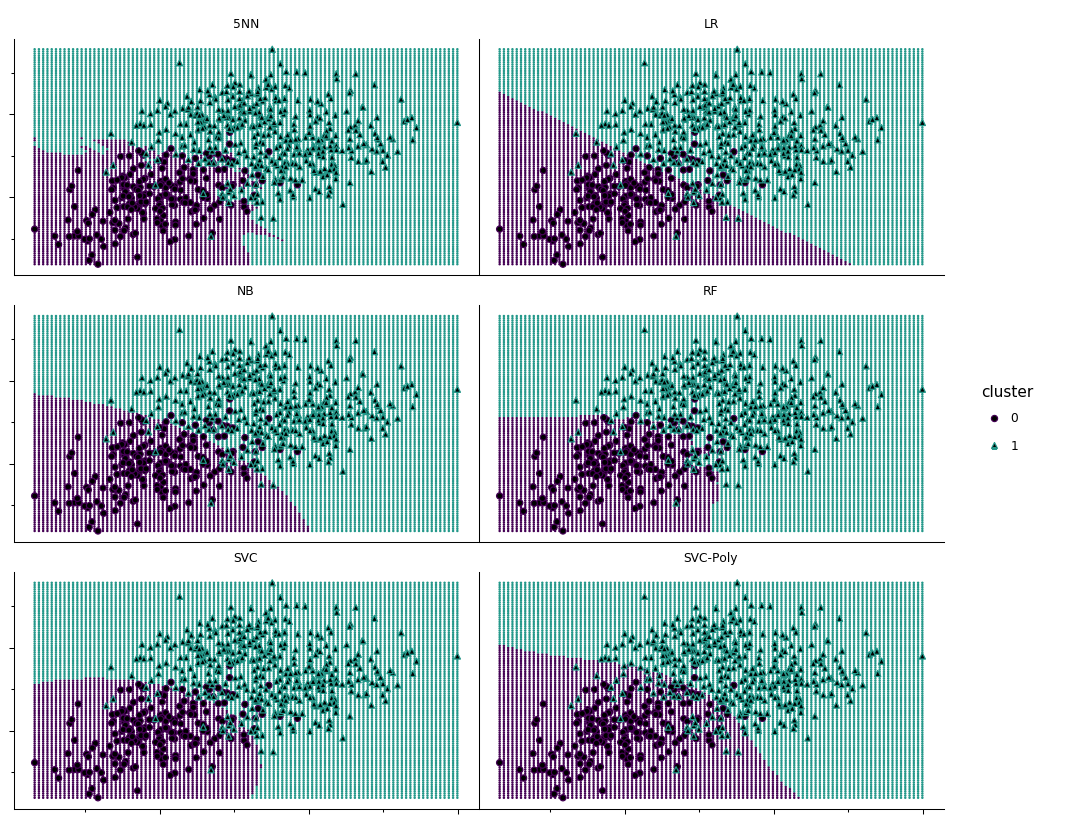

<ggplot: (7578063557)>

In [590]:
plot_boundries(non_lin_clfs, non_linear_data, 100, figure_size = (12, 10))

## ToDo

1. Add LDA/QDA
1. Add best (e.g Bayes-classifier) decision boundaries